Neste notebook, vamos mostrar como calcular o Moran's Index univariado e bivariado utilizando dados de pluviometria e temperatura do INMET (Instituto Nacional de Meteorologia) de abril de 2021.

In [1]:
## Bibliotecas para tratamento de dados, plotting e leitura de arquivos de dados
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob

## Geopandas: Utilizamos para conseguir ler arquivos do tipo Shape (.shp) 
import geopandas as gpd

## Pacotes PySAL
# libpysal: Biblioteca core do PySAL. Utilizamos o método de vizinhança Queen
from libpysal.weights.contiguity import Queen
# ESDA (Exploratory Spatial Data Analysis): utilizamos para o cálculo de correlação
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
# SPlot: Utilizamos para fazer os plots espaciais
from splot.esda import moran_scatterplot, plot_local_autocorrelation, lisa_cluster, plot_moran_bv

# Para exibirmos várias linhas e colunas
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [2]:
MAPAS_PATH = "BR_UF_2020/"
DATA_PATH = "Histórico de Dados Meteorológicos - 2021/"

## Computamos as vizinhanças e pesos

Carregamos o shape file

<AxesSubplot:>

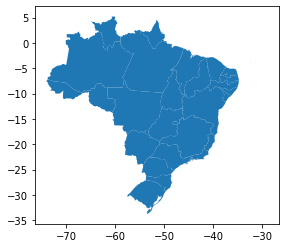

In [3]:
gdf = gpd.read_file(MAPAS_PATH + "BR_UF_2020.shp")
gdf.plot()

In [4]:
gdf

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,geometry
0,11,Rondônia,RO,Norte,"POLYGON ((-65.38150 -10.42907, -65.38013 -10.4..."
1,12,Acre,AC,Norte,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828..."
2,13,Amazonas,AM,Norte,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620..."
3,14,Roraima,RR,Norte,"POLYGON ((-63.96008 2.47313, -63.96041 2.47416..."
4,15,Pará,PA,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ..."
5,16,Amapá,AP,Norte,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2..."
6,17,Tocantins,TO,Norte,"POLYGON ((-48.23291 -5.94757, -48.23163 -5.946..."
7,21,Maranhão,MA,Nordeste,"MULTIPOLYGON (((-44.96620 -1.27114, -44.96081 ..."
8,22,Piauí,PI,Nordeste,"POLYGON ((-42.91509 -6.64795, -42.91636 -6.644..."
9,23,Ceará,CE,Nordeste,"POLYGON ((-41.18292 -4.01797, -41.18552 -4.017..."


In [5]:
gdf.shape

(27, 5)

Aqui setamos o tipo de contiguidade que desejamos. Existem dois tipos predefinidos para definir vizinhança, que são o `Rook` e o `Queen`. A contiguidade `Rook` considera vizinhos aquelas regiões que têm bordas em comum. A contiguidade `Queen` é uma extensão da contiguidade `Rook` que considera também como vizinhas aquelas regiões cuja borda contém somente um ponto em comum. O nome vem das peças do jogo de xadrez, e os métodos têm bastante diferença quando nossas regiões estão dispostas em _grid_ [[1]](#refs).

Aqui, vamos considerar o método `Queen` para calcular a matriz de contiguidade, mas o método `Rook` também poderia ser utilizado.

O resultado é uma matriz esparsa binária, indicando se uma região é vizinha de outra (1) ou não (0).

In [6]:
weights = Queen.from_dataframe(gdf)

In [7]:
W_matrix, ids = weights.full()

In [8]:
list(W_matrix[0]) # notar que é uma matriz de 0's e 1's

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0]

Vamos também normalizar a matriz por linhas (`r`) usando a função `transform` [[2]](#refs).

In [9]:
weights.transform = 'r'

In [10]:
W_matrix, ids = weights.full()

In [11]:
list(W_matrix[0]) # notar que é os 1's foram normalizados

[0.0,
 0.3333333333333333,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.0]

Vemos quantos não zeros temos na matriz.

In [12]:
str(np.round(weights.pct_nonzero, 2)) + "%"

'13.99%'

Vemos quantas regiões temos (`n`). Nossa matriz tem `n * n` valores.

In [13]:
weights.n

27

De fato, temos 27 UFs no Brasil (26 estados mais o Distrito Federal).

## Preparamos os dados de pluviometria

Vamos carregar os dados meteorológicos de todas as cidades brasileiras disponíveis. [[3]](#refs)

In [14]:
df_meteorologicos = pd.DataFrame()

In [15]:
meteo_file_paths = glob.glob(DATA_PATH + "INMET*.CSV")
meteo_file_paths

['Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A002_GOIANIA_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A003_MORRINHOS_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A005_PORANGATU_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A011_SAO SIMAO_01-01-2021_A_30-04-2021.CSV',
 'Histórico de Dados Meteorológicos - 2021\\INMET_CO_GO_A012_LUZIANIA_

In [ ]:
%%time
for path in meteo_file_paths:
    try:
        print(f"Lendo arquivo {path}...")
        df_file = pd.read_csv(path, encoding="ISO-8859-1", sep=";", header=8)
        print(f"Arquivo {path} lido com sucesso!")
        # Adicionamos as informações da cidade e do estado, presentes no nome do arquivo
        filename = path.split('\\')[1]
        region = filename.split("_")[1]
        uf = filename.split("_")[2]
        city = filename.split("_")[4]
        print(f"Arquivo referente a {uf} - {city}")
        df_file["Região"] = region
        df_file["UF"] = uf
        df_file["Cidade"] = city
        # Concatenamos o dataframe da cidade
        df_meteorologicos = pd.concat([df_meteorologicos, df_file])
        print(f"Shape final: {df_meteorologicos.shape}")
    except Exception as e:
        print(f"Falha ao ler arquivo {path} :-(")
        print(e)
    print()

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A001_BRASILIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - BRASILIA
Shape final: (2880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A042_BRAZLANDIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - BRAZLANDIA
Shape final: (5760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A045_AGUAS EMENDADAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a DF - AGUAS EMENDADAS
Shape final: (8640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_DF_A046_GAMA (PONTE ALTA)_01-01-2


Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A037_SILVANIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A037_SILVANIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a GO - SILVANIA
Shape final: (86400, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A056_CRISTALINA (FAZENDA SANTA MONICA)_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_GO_A056_CRISTALINA (FAZENDA SANTA MONICA)_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a GO - CRISTALINA (FAZENDA SANTA MONICA)
Shape final: (89280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A702_CAMPO GRANDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_A702_CAMPO GRANDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - CAMPO GRANDE
Shape final: (92160, 23)

Lendo arquivo Histórico de Dados 

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S701_ANGELICA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - ANGELICA
Shape final: (172800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S702_ARAL MOREIRA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S702_ARAL MOREIRA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - ARAL MOREIRA
Shape final: (175680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S703_BANDEIRANTES_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S703_BANDEIRANTES_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MS - BANDEIRANTES
Shape final: (178560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S704_BONITO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MS_S704_BONITO_01-01-2021_A_30-04-2021

Shape final: (250560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A912_CAMPO VERDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A912_CAMPO VERDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - CAMPO VERDE
Shape final: (253440, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A913_COMODORO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A913_COMODORO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - COMODORO
Shape final: (256320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A914_JUARA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A914_JUARA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MT - JUARA
Shape final: (259200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_CO_MT_A915_PARANATINGA_01-01-2

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A303_MACEIO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AL - MACEIO
Shape final: (328320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A323_PAO DE ACUCAR_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A323_PAO DE ACUCAR_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AL - PAO DE ACUCAR
Shape final: (331200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A327_PALMEIRA DOS INDIOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A327_PALMEIRA DOS INDIOS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AL - PALMEIRA DOS INDIOS
Shape final: (334080, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A353_ARAPIRACA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_AL_A353_ARAPIRA

Shape final: (408960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A430_PIATA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A430_PIATA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - PIATA
Shape final: (411840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A431_CONDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A431_CONDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - CONDE
Shape final: (414720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A432_BURITIRAMA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A432_BURITIRAMA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a BA - BURITIRAMA
Shape final: (417600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_BA_A433_BRUMADO_01-01-2021_A_30-04-2021

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A315_BARBALHA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - BARBALHA
Shape final: (492480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A319_IGUATU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A319_IGUATU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - IGUATU
Shape final: (495360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A324_TAUA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A324_TAUA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a CE - TAUA
Shape final: (498240, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A325_QUIXERAMOBIM_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_CE_A325_QUIXERAMOBIM_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo

Shape final: (576000, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A310_AREIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A310_AREIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PB - AREIA
Shape final: (578880, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A313_CAMPINA GRANDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A313_CAMPINA GRANDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PB - CAMPINA GRANDE
Shape final: (581760, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A320_JOAO PESSOA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A320_JOAO PESSOA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PB - JOAO PESSOA
Shape final: (584640, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PB_A321_P

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A335_PIRIPIRI_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - PIRIPIRI
Shape final: (659520, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A336_ALVORADA DO GURGUEIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A336_ALVORADA DO GURGUEIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - ALVORADA DO GURGUEIA
Shape final: (662400, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A337_CARACOL_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A337_CARACOL_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PI - CARACOL
Shape final: (665280, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A343_PICOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_PI_A343_PICOS_01-01-2021_A_30-

Shape final: (740160, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A451_ITABAIANA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A451_ITABAIANA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SE - ITABAIANA
Shape final: (743040, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A453_NOSSA SENHORA DA GLORIA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_NE_SE_A453_NOSSA SENHORA DA GLORIA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a SE - NOSSA SENHORA DA GLORIA
Shape final: (745920, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AC_A102_PARQUE ESTADUAL CHANDLESS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AC_A102_PARQUE ESTADUAL CHANDLESS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AC - PARQUE ESTADUAL CHANDLESS
Shape final: (748800,

Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AM_A144_NOVO ARIPUANA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AM - NOVO ARIPUANA
Shape final: (820800, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A242_OIAPOQUE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A242_OIAPOQUE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AP - OIAPOQUE
Shape final: (823680, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A244_PORTO GRANDE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A244_PORTO GRANDE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a AP - PORTO GRANDE
Shape final: (826560, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A249_MACAPA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_AP_A249_MACAPA_01-01-2021_A_30-04-2021.CSV lido

Shape final: (904320, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A247_XINGUARA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A247_XINGUARA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - XINGUARA
Shape final: (907200, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A248_CAPITAO POCO_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A248_CAPITAO POCO_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - CAPITAO POCO
Shape final: (910080, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A250_SANTAREM_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A250_SANTAREM_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a PA - SANTAREM
Shape final: (912960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_PA_A252_DOM ELISEU_01-

Shape final: (984960, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A052_SANTA ROSA DO TOCANTINS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A052_SANTA ROSA DO TOCANTINS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a TO - SANTA ROSA DO TOCANTINS
Shape final: (987840, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A053_ALMAS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A053_ALMAS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a TO - ALMAS
Shape final: (990720, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A054_ARAGUACU_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_N_TO_A054_ARAGUACU_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a TO - ARAGUACU
Shape final: (993600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_

Shape final: (1065600, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A515_VARGINHA_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A515_VARGINHA_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - VARGINHA
Shape final: (1068480, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A516_PASSOS_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A516_PASSOS_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - PASSOS
Shape final: (1071360, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A517_MURIAE_01-01-2021_A_30-04-2021.CSV...
Arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A517_MURIAE_01-01-2021_A_30-04-2021.CSV lido com sucesso!
Arquivo referente a MG - MURIAE
Shape final: (1074240, 23)

Lendo arquivo Histórico de Dados Meteorológicos - 2021\INMET_SE_MG_A518_JUIZ DE FORA_01-01-2021_A_3

In [ ]:
df_meteorologicos.reset_index(drop=True, inplace=True)

In [ ]:
df_meteorologicos.head()

In [ ]:
df_meteorologicos.shape

In [ ]:
print(f"Temos {len(df_meteorologicos['Cidade'].unique())} cidades diferentes.")

Separamos os dados de Precipitação

In [ ]:
df_precipitacao = df_meteorologicos[["Data", "Hora UTC", "Região", "UF", "Cidade", "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"]]

In [ ]:
df_precipitacao.info()

Transformamos os campos de data e de precipitação

In [ ]:
df_precipitacao["Data"].value_counts(dropna=False).sort_index()

In [ ]:
df_precipitacao["Data"] = pd.to_datetime(df_precipitacao["Data"], format="%Y/%m/%d")

In [ ]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].value_counts(dropna=False)

In [ ]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"] = df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].str.replace(",", ".").astype(np.float64)

Vamos utilizar somente os dados de abril de 2021

In [ ]:
df_precipitacao = df_precipitacao[(df_precipitacao["Data"] >= "2021-04-01") & (df_precipitacao["Data"] <= "2021-04-30")]

In [ ]:
print(f"Temos dados de {len(df_precipitacao['UF'].unique())} UFs em 2021-04.")

In [ ]:
df_precipitacao

Vamos tirar a média das pluviometrias em cada estado

In [ ]:
df_precipitacao.groupby("UF")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()

Temos só nulos em Roraima, no mês de 04-2021. Vamos imputar a média da região Norte

In [ ]:
medias_por_regiao = df_precipitacao.groupby("Região")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()
medias_por_regiao

In [ ]:
df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"] = df_precipitacao["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].fillna(medias_por_regiao["N"])

Calculamos as médias pluviométricas de cada estado

In [ ]:
medias_por_uf = df_precipitacao.groupby("UF")["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].mean()
medias_por_uf

Vamos utilizar uma abordagem por estado brasileiro, para simplificar o cálculo, assim como a aplicada no [artigo 1](https://marcospaulomoretti.medium.com/autocorrela%C3%A7%C3%A3o-espacial-382c5af6d2ed), por dois motivos:
- Não temos os dados pluviométricas de todos os municípios (temos 589/5570).
- Nos dados pluviométricos não tem o CODMUN (código do município), então precisaríamos fazer um match de string.

Ao contrário do [artigo 1](https://marcospaulomoretti.medium.com/autocorrela%C3%A7%C3%A3o-espacial-382c5af6d2ed), estamos utilizando dados de 04/2021, pois na data de obtenção dos dados do INMET ainda não havia os dados de 05/2021.

In [ ]:
df_medias_pluviometricas = pd.DataFrame(medias_por_uf).reset_index()
df_medias_pluviometricas.rename(columns={"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)" : "MÉDIA PLUVIOMÉTRICA EM ABR/2021"}, inplace=True)
df_medias_pluviometricas

Criamos um novo dataframe com o Geometry (em `gdf`) e o dado pluviométrico. Assim, acabamos por ordenar a variável de Média Pluviométrica de acordo com a ordenação dos estados em `gdf`.

In [ ]:
df_final = pd.merge(
    gdf,
    df_medias_pluviometricas,
    left_on="SIGLA_UF",
    right_on="UF",
    how="left"
)

In [ ]:
df_final

## Cálculo do Moran's I

In [ ]:
help(Moran)

* #### Autocorrelação espacial global

Medida da autocorrelação espacial da variável `MÉDIA PLUVIOMÉTRICA EM ABR/2021` (chamamos de `y`)

In [ ]:
y = df_final["MÉDIA PLUVIOMÉTRICA EM ABR/2021"].copy()

In [ ]:
moran = Moran(y, weights)

In [ ]:
moran.I

O valor de autocorrelação é **positivo.**

```
The Spatial Autocorrelation (Global Moran's I) tool is an inferential statistic, which means that the results of the analysis are always interpreted within the context of its null hypothesis. 
```
(Fonte: [[4]](#refs))

O valor do Moran's I é uma estatística que deve ser avaliada no contexto de um teste de hipótese sobre a aleatoriedade da distribuição dos valores de `y` no espaço.


Na prática, o valor do índice calculado com `moran.I` é um valor normalizado: calcula-se sua esperança teórica, calcula-se seu desvio-padrão teórico, e o Moran's I é o _z-score_ ($I = \frac{I - E(I)}{std(I)}$). É a partir dessa estatística que aceitamos ou rejeitamos a hipótese inicial (H0) de os dados de `y` estarem distribuídos no espaço de forma aleatória. [[5]](#refs)

A significância do valor de Moran's I pode ser calculado de duas formas [[6]](#refs):
- Observando quanto o valor obtido para `I` é maior/menor do que o valor esperado (esperança) para o índice (`EI`), assumindo que `y` siga uma distribuição normal
- Observando permutações aleatórias dos valores de `y` no espaço e verificando a distribuição dos valores de `I` que obtemos. No caso, é definido um valor de permutações para esse cálculo, que por padrão é `permutations=999`

Como temos `n = 27 < 40`, a hipótese de normalidade pode não ser verdadeira, uma vez que a distribuição se aproxima de uma normal conforme `n` cresce. Logo, vamos avaliar a significância de `I` a partir de permutações dos dados no espaço.

In [ ]:
#print("Significância em relação à esperança do Moran's I (EI), assumindo normalidade de y:")
#print(f"Esperança de I = {moran.EI}")
#print(f"P-valor de I   = {moran.p_norm}")

In [ ]:
print("Significância em relação à distribuição dos índices I, após permutações aleatórias de y no espaço:")
print(f"Qtde. de permutações = {moran.permutations}")
print(f"Esperança de I       = {moran.EI_sim}")
print(f"P-valor de I         = {moran.p_sim}")

Percebemos que o índice obtido é bem maior que a média esperada, e é significativo em relação a um grau de significância de 5% (p-valor = 0.001 < 5%)

Concluímos que o valor de `Moran's I = 0.7695` é **estatisticamente significativo**, e existe autocorrelação espacial positiva na variável `Média pluviométrica`.

* Visualização do Moran's I

In [ ]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
ax.set_xlabel('Média Pluviométrica')
ax.set_ylabel('Lag espacial da Média Pluviométrica')
plt.show()

O valor do Moran's I é o coeficiente da reta de regressão entre a `Média pluviométrica` e `lag(Média pluviométrica)`.

* #### Autocorrelação espacial local

Aqui, é feita a decomposição do Moran’s I de forma a construir uma medida localizada de autocorrelação. A ideia é encontrar _hot spots_ e _cold spots_, que são regiões em que se encontram respectivamente pontos com maior e menor correlação espacial.

In [ ]:
moran_loc = Moran_Local(y, weights)

Fazemos um _scatterplot_ que divide as áreas em 4 grupos:

- _High-high_: 1º quadrante (em vermelho no gráfico)
- _Low-high_: 2º quadrante
- _Low-low_: 3º quadrante (em amarelo no gráfico)
- _High-low_: 4º quadrante

O parâmetro `p` é o p-valor que caracteriza o limite de significância no Moran's Local:

- Os pontos são coloridos de **vermelho** se forem considerados _hot spots_
- Os pontos são coloridos de **azul escuro** se forem considerados _cold spots_

Os pontos ainda podem ser coloridos de **amarelo** ou de **azul claro**, se forem respectivamente _High-Low_ ou _Low-High_. Os pontos em cinza não se caracterizam nem como _hot spots_ nem como _cold spots_.

Manteremos nosso `p` igual a 5%.

In [ ]:
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Média Pluviométrica')
ax.set_ylabel('Lag espacial da Média Pluviométrica')
plt.show()

* Visualizamos os clusters em um mapa

In [ ]:
lisa_cluster(moran_loc, df_final, p=0.05, figsize=(9,9))
plt.show()

* Visão combinada

In [ ]:
plot_local_autocorrelation(moran_loc, df_final, 'MÉDIA PLUVIOMÉTRICA EM ABR/2021')
plt.show()

Observamos que os estados do AM, RR, PA, AP ao norte do país têm uma tendência a ter regiões de alta pluviometria vizinhas de regiões de alta pluviometria, ao passo que bnoa parte dos estados no sul e sudeste do país têm uma tendência a terem regiões de baixa pluviometria vizinhas de regiões de baixa pluviometria.

Percebemos que existe uma forte tendência Sul-Sudeste (LL = menor pluviometria) em direção ao Norte (HH = Alta pluviometria).

## Bivariate Moran's I

* Preparação dos dados

Aqui, vamos avaliar o grau de correlação espacial de **duas variáveis.**

Assim como no [artigo 1](https://marcospaulomoretti.medium.com/autocorrela%C3%A7%C3%A3o-espacial-382c5af6d2ed), vamos tomar a variável temperatura e calcular o grau de correlação espacial dessas duas variáveis.

Para isso, vamos pegar os campos `TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)` e `TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)`, tirar a média, e em seguida tirar a média por estado, como fizemos com a pluviometria.

O significado dos campos foi obtido do Glossário de Dados do INMET [[7]](#refs).

In [ ]:
df_temperatura = df_meteorologicos[["Data", "Hora UTC", "Região", "UF", "Cidade", "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)", "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"]]

In [ ]:
df_temperatura.info()

Transformamos os campos de data e de temperatura

In [ ]:
df_temperatura["Data"].value_counts(dropna=False).sort_index()

In [ ]:
df_temperatura["Data"] = pd.to_datetime(df_temperatura["Data"], format="%Y/%m/%d")

In [ ]:
df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].value_counts(dropna=False)

In [ ]:
df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].value_counts(dropna=False)

In [ ]:
df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"] = df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(np.float64)
df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"] = df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].str.replace(",", ".").astype(np.float64)

Vamos utilizar somente os dados de abril de 2021

In [ ]:
df_temperatura = df_temperatura[(df_temperatura["Data"] >= "2021-04-01") & (df_temperatura["Data"] <= "2021-04-30")]

In [ ]:
print(f"Temos dados de {len(df_temperatura['UF'].unique())} UFs em 2021-04.")

In [ ]:
df_temperatura

Vamos ver os nulos

In [ ]:
df_temperatura.isnull().sum()

Vamos substituir os nulos nas temperaturas pela média da região em que o estado se encontra

In [ ]:
medias_max_por_regiao = df_temperatura.groupby("Região")["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].mean()
medias_max_por_regiao

In [ ]:
medias_min_por_regiao = df_temperatura.groupby("Região")["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].mean()
medias_min_por_regiao

In [ ]:
for regiao in ["CO", "N", "NE", "S", "SE"]:
    idx_max = df_temperatura[(df_temperatura["Região"] == regiao) & (df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"].isna())].index
    df_temperatura.loc[idx_max, "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"] = medias_max_por_regiao[regiao]
    idx_min = df_temperatura[(df_temperatura["Região"] == regiao) & (df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"].isna())].index
    df_temperatura.loc[idx_min, "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"] = medias_min_por_regiao[regiao]

In [ ]:
df_temperatura.isnull().sum()

Vamos tirar a média da temperatura máxima e da mínima em cada cidade.

In [ ]:
df_temperatura["Temperatura média (°C)"] = (df_temperatura["TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"] + df_temperatura["TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"]) / 2

Em seguida, vamos tirar a média por estado.

In [ ]:
medias_por_uf = df_temperatura.groupby("UF")["Temperatura média (°C)"].mean()
medias_por_uf

In [ ]:
df_medias_temperatura = pd.DataFrame(medias_por_uf).reset_index()
df_medias_temperatura.rename(columns={"Temperatura média (°C)" : "Média da temperatura média (°C) em ABR/2021"}, inplace=True)
df_medias_temperatura

In [ ]:
df_medias_temperatura.sort_values(by="Média da temperatura média (°C) em ABR/2021", ascending=False)

Como esperado, as temperaturas médias nas regiões Nordeste e Norte são em geral mais elevadas.

Criamos um dataframe com o Geometry (em `gdf`), o dado de temperatura e o dado pluviométrico. Assim, acabamos por ordenar a variável de Média Pluviométrica de acordo com a ordenação dos estados em `gdf`.

In [ ]:
# Merge dos dados pluviométricos
df_final = pd.merge(
    gdf,
    df_medias_pluviometricas,
    left_on="SIGLA_UF",
    right_on="UF",
    how="left"
)

# Merge dos dados de temperatura
df_final = pd.merge(
    df_final,
    df_medias_temperatura,
    left_on="SIGLA_UF",
    right_on="UF",
    how="left"
)

In [ ]:
df_final.drop(columns=["UF_x", "UF_y"], inplace=True)

In [ ]:
df_final

* ### Moran's I Bivariado Global

In [ ]:
help(Moran_BV)

Como temos duas variáveis, precisamos saber se vamos calcular o _lag_ da `Média da temperatura` ou da `Média da pluviometria`.

Vamos supor que queremos entender se a temperatura está influenciando na pluviometria da vizinhança de uma dada região. Neste caso, nossa variável referência `x` é a `Média da temperatura`, ao passo que `y` é a `Média da pluviometria`, da qual calcularemos o _lag_.

In [ ]:
x = df_final['Média da temperatura média (°C) em ABR/2021'].values
y = df_final['MÉDIA PLUVIOMÉTRICA EM ABR/2021'].values # variável que utilizaremos como lag

In [ ]:
moran_bv = Moran_BV(x, y, weights)

É importante notar que `Moran_BV(x, y, weights) != Moran_BV(y, x, weights)`, pois estamos calculando o _lag_ com variáveis diferentes.

In [ ]:
moran_bv.I

O valor de autocorrelação é **positivo.**

- Cálculo da significância

Faremos da mesma forma que o cálculo do Moran's I univariado. Vamos utilizar permutações para rejeitar a hipótese nula (H0) de aleatoriadade espacial dos `y` com significância (p-valor) de 5%.

In [ ]:
print("Significância em relação à distribuição dos índices I, após permutações aleatórias de y no espaço:")
print(f"Qtde. de permutações = 999")
print(f"Esperança de I       = {moran_bv.EI_sim}")
print(f"P-valor de I         = {moran_bv.p_sim}")

Percebemos que o índice obtido é bem maior que a média esperada, e **é significativo** em relação a um grau de significância de 5% (p-valor = 0.001 < 5%). 

Ou seja, existe uma correlação espacial positiva entre pluviometria e temperatura.

- Visualização do Moran's I

In [ ]:
plot_moran_bv(moran_bv)
plt.show()

Aqui podemos observar a distribuição normal de referência para o Moran's index, e a linha vermelha à direita mostra o valor de `moran_bv.I` obtido. O valor da área sob a curva, para `bv_index > 0.74` é menor que o p-valor, de modo que rejeitamos a hipótese nula (H0) de distribuição aleatória de `y`.

* ### Moran's I Bivariado Local

In [ ]:
moran_loc_bv = Moran_Local_BV(y, x, weights)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Média pluviométrica em abr/2021')
ax.set_ylabel('LAG ESPACIAL da média da temperatura média (°C) em ABR/2021')
plt.show()

In [ ]:
lisa_cluster(moran_loc_bv, df_final, p=0.05, figsize=(9,9))
plt.show()

Observamos que os estados do AM, RR, PA, AP ao norte do país têm uma tendência a ter regiões de alta pluviometria vizinhas de regiões de alta temperatura, ao passo que os estados no sul e sudeste do país têm uma tendência a terem regiões de baixa pluviometria vizinhas de regiões de baixa temperatura.

Isso configura uma tendência parecida com a que foi vista para pluviometria, de modo que temperatura parece seguir a mesma tendência espacial.

## Conclusão

Podemos constatar que no mês de abril de 2021, de fato, existe uma tendência espacial na Média pluviométrica, e que a distribuição das Médias das temperaturas no espaço sugere uma influência espacial da temperatura na pluviometria das regiões.

De fato, podemos observar que principalmente no Sul e no Sudeste do Brasil temos _cold spots_, ao passo que no Norte temos _hot spots_ de pluviometria, o que parece fazer sentido se considerarmos o perfil climatológico brasileiro.

Em todo caso, por mais que os p-valores informem que existe significância no valores de Moran's index obtidos, é importante ressaltar a máxima que **correlação não implica causalidade**. Então, no caso bivariado, por exemplo, não podemos afirmar que a pluviometria alta nos _hot spots_ seja a causa de um aumento de temperatura na vizinhança devido à alta correlação obtida, mas sim que os valores seguem uma tendência espacial semelhante.

<a id="refs"></a>
## Referências

[1] https://www.biomedware.com/files/documentation/clusterseer/Concepts/Polygon_contiguity.htm

[2] http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html

[3] Histórico de Dados Meteorológicos (2021) - Instituto Nacional de Meteorologia:
https://portal.inmet.gov.br/dadoshistoricos

[4] https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm

[5] https://aurin.org.au/resources/workbench-user-guides/portal-user-guides/analysing-your-data/spatial-autocorrelation-tools/bivariate-morans-i/

[6] https://splot.readthedocs.io/en/stable/users/tutorials/autocorrelation.html#moran-s-i

[7] Glossário de dados:
https://portal.inmet.gov.br/glossario/glossario
(Procurar TEMPERATURA MÉDIA)

- Outras referências:

[.] https://nbviewer.jupyter.org/github/pysal/libpysal/blob/master/notebooks/weights.ipynb

[.] Malha municipal - IBGE:
https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais/15774-malhas.html?=&t=downloads